In [1]:
import os
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from src.dataset import *
from src.model import *

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
config = {
    'local_depth': 16,
    'local_convdepth': 32,
    'local_imagesize': 256,
    'global_depth': 5,
    'global_convdepth': 64,
    'global_imagesize': 128,
    'scale': 0.25}

model = CIEXYZNet(**config)
if os.listdir("model_weights"):
    model.load_weights("model_weights/model")

2022-06-01 03:57:25.678758: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:938] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0d:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-06-01 03:57:25.705270: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:938] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0d:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-06-01 03:57:25.705652: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:938] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0d:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-06-01 03:57:25.706671: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with t

In [3]:
BATCH_SIZE = 4
EPOCHS = 150
LR = 1e-4

loss_fn = CompiledMAELoss()
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
metric_fn = tf.keras.metrics.Mean()

train_dataset = DataLoader(train_set="training", batch_size=BATCH_SIZE)
test_dataset = DataLoader(train_set="validation", batch_size=BATCH_SIZE)
val_dataset = DataLoader(train_set="testing", batch_size=BATCH_SIZE)

train_steps = len(train_dataset)

history_path = "history/history.json"
if os.path.exists(history_path):
    with open(history_path, "r") as f:
        history = json.load(f)
else:
    history = {'loss': [], 'val_loss': []}

best_val = np.inf
for epoch in range(1, EPOCHS+1):
    print(f"Epoch {epoch}/{EPOCHS}")
    progbar = tf.keras.utils.Progbar(
        train_steps, interval=0.05,
        stateful_metrics=['loss', 'val_loss'])
    for step, train_batch in enumerate(train_dataset.data):
        sRGB_image = train_batch['sRGB_image']
        XYZ_image = train_batch['XYZ_image']
        with tf.GradientTape() as tape:
            train_logits = model(sRGB_image, training=True)
            train_loss = loss_fn((XYZ_image, sRGB_image), train_logits) 

        grads = tape.gradient(train_loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        metric_fn.update_state(train_loss)
        train_mae = metric_fn.result().numpy()
        progbar.update(step, values=[('loss', train_mae)], finalize=False)
    
    metric_fn.reset_state()
    
    for val_batch in val_dataset.data:
        sRGB_image = val_batch['sRGB_image']
        XYZ_image = val_batch['XYZ_image']
        val_logits = model(sRGB_image)
        val_loss = loss_fn((XYZ_image, sRGB_image), val_logits) 
        metric_fn.update_state(val_loss)

    val_mae = metric_fn.result().numpy()
    values = {'loss': train_mae, 'val_loss': val_mae}
    progbar.update(train_steps, values=values.items(), finalize=True)
    metric_fn.reset_state()

    if best_val > val_mae:
        best_val = val_mae
        model.save_weights("model_weights/model")
        print("Model improved and saved")

    history['loss'].append(np.float64(train_mae))
    history['val_loss'].append(np.float64(val_mae))

    with open("history/history.json", "w") as f:
        json.dump(history, f, indent=4)

Epoch 1/150


2022-06-01 03:57:27.976902: I tensorflow/stream_executor/cuda/cuda_dnn.cc:379] Loaded cuDNN version 8400
2022-06-01 03:57:28.897556: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


242/242 [==============================] - 24s 88ms/step - loss: 1.7534 - val_loss: 0.3844
Epoch 2/150
242/242 [==============================] - 21s 86ms/step - loss: 0.4012 - val_loss: 0.2568
Epoch 3/150
242/242 [==============================] - 21s 86ms/step - loss: 0.2972 - val_loss: 0.1785
Epoch 4/150
242/242 [==============================] - 22s 89ms/step - loss: 0.2330 - val_loss: 0.1619
Epoch 5/150
242/242 [==============================] - 22s 89ms/step - loss: 0.1999 - val_loss: 0.1293
Epoch 6/150
242/242 [==============================] - 22s 89ms/step - loss: 0.1686 - val_loss: 0.1168
Epoch 7/150
242/242 [==============================] - 22s 90ms/step - loss: 0.1560 - val_loss: 0.1118
Epoch 8/150
242/242 [==============================] - 25s 100ms/step - loss: 0.1407 - val_loss: 0.1025
Epoch 9/150
242/242 [==============================] - 22s 90ms/step - loss: 0.1294 - val_loss: 0.1049
Epoch 10/150
242/242 [==============================] - 24s 97ms/step - loss: 0.1213

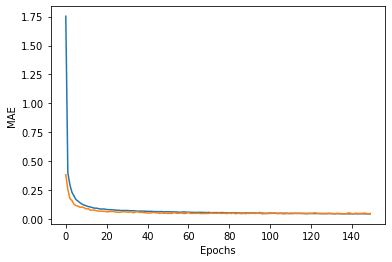

In [10]:
history = pd.read_json("history/history.json", orient="column")
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.show()

In [50]:
for test_batch in test_dataset.data:
    sRGB_image = test_batch['sRGB_image']
    XYZ_image = test_batch['XYZ_image']
    test_logits = model(sRGB_image)
    test_loss = loss_fn((XYZ_image, sRGB_image), test_logits) 
    metric_fn.update_state(test_loss)

print("Test loss:", metric_fn.result().numpy())

Test loss: 0.056307733


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Filename: a0348-07-07-07-at-09h42m42s-_MG_2151.JPG


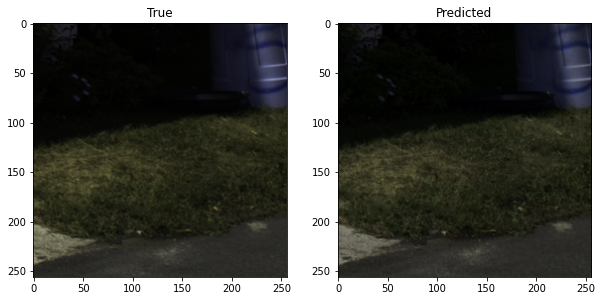

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Filename: a1100-_DGW6248.JPG


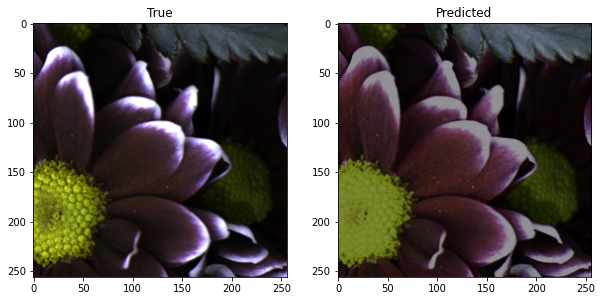

Filename: a0463-jmac_DSC2316.JPG


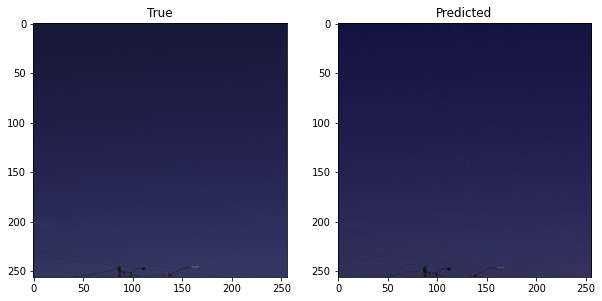

Filename: a1683-kme_028.JPG


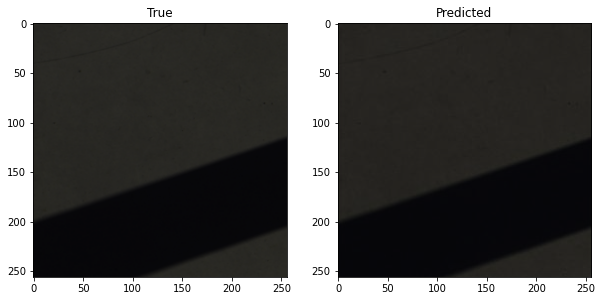

In [49]:
test_batch = next(iter(test_dataset.data))
for i in range(len(test_batch['filename'])):
    test_logits = model(test_batch['sRGB_image'])
    print("Filename:", test_batch['filename'][i].numpy().decode())
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(test_batch['XYZ_image'][i].numpy())
    ax[1].imshow(test_logits[0][i].numpy())
    ax[0].set_title("True")
    ax[1].set_title("Predicted")
    plt.show()